* https://github.com/DavexPro/dogs-vs-cats/blob/master/transfer_learning.ipynb

In [1]:
import os
# import cv2
import copy
import time
import torch
import random
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from PIL import Image
# from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
freq_print = 20

use_gpu = True
torch.backends.cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
use_cuda

True

In [3]:
class TestImageFolder(Dataset):
    def __init__(self, root, transform=None):
        images = []
        for filename in os.listdir(root):
            if filename.endswith('jpg'):
                images.append('{}'.format(filename))

        self.root = root
        self.imgs = images
        self.transform = transform

    def __getitem__(self, index):
        filename = self.imgs[index]
        img = Image.open(os.path.join(self.root, filename))
        if self.transform is not None:
            img = self.transform(img)
        return img, filename

    def __len__(self):
        return len(self.imgs)

In [4]:

train_transform  = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

train_dataset = datasets.ImageFolder('../data/dogsandcats/train/', train_transform)
valid_dataset = datasets.ImageFolder('../data/dogsandcats/train', test_transform)
test_dataset = TestImageFolder('../data/dogsandcats/test1/', test_transform)

shuffle = True
valid_ratio = 0.15
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_ratio * num_train))

if shuffle:
    np.random.seed(42)
    np.random.shuffle(indices)

train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler, num_workers=16, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, sampler=valid_sampler, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

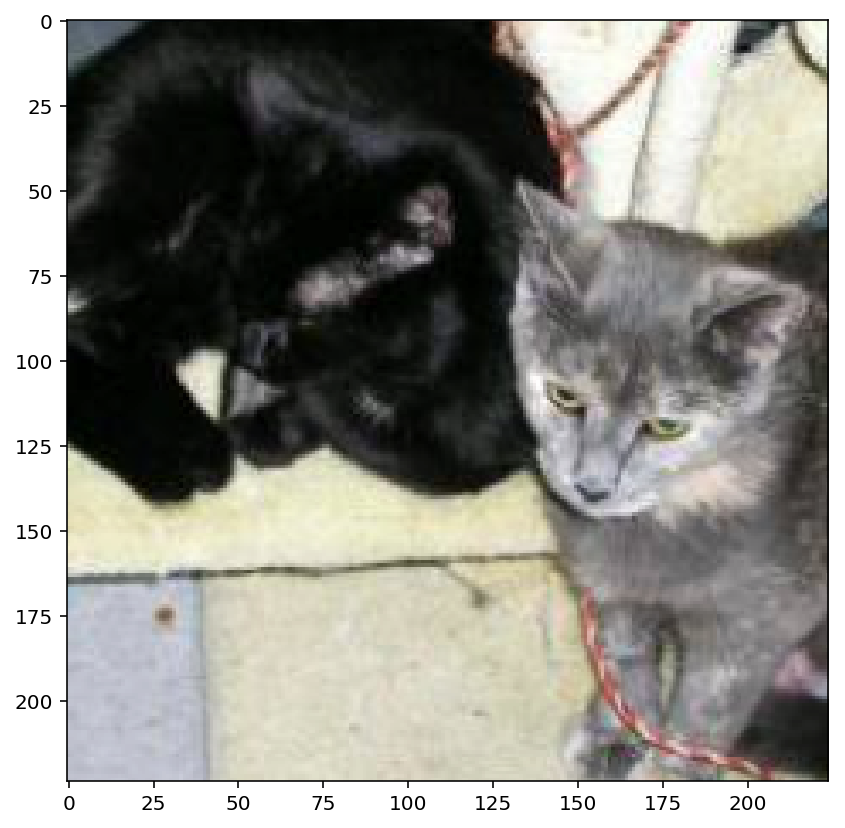

In [6]:
import torchvision.utils as utils
plt.figure(figsize=(12, 7))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(test_loader))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out)

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataset_sizes = len(train_loader.sampler)
                data_loader = train_loader
                scheduler.step()
                model.train(True)
            else:
                dataset_sizes = len(valid_loader.sampler)
                data_loader = valid_loader
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for ix, data in enumerate(data_loader):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                if ix % freq_print == 0:
                    print('Epoch:[{0}][{1}/{2}]\tLoss: {3}\tCorrect: {4}'.format(epoch + 1, ix, len(data_loader), 
                                                                               running_loss / (inputs.size(0)*(ix+1)), 
                                                                               running_corrects / (inputs.size(0)*(ix+1))))

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects / dataset_sizes

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                torch.save(model, 'best_model.pth.tar')
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:

model_ft = models.resnet152(pretrained=True)
num_feas = model_ft.fc.in_features

for param in model_ft.parameters():
    param.requires_grad = False
    
model_ft.fc = nn.Linear(num_feas, 2)
model_ft.cuda()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100.0%


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [9]:
# Cross Entropy
criterion = nn.CrossEntropyLoss().cuda()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_para = torch.nn.DataParallel(model_ft).cuda()
model_para = train_model(model_para, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

Epoch 1/2
----------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:[1][0/306]	Loss: 0.7745286822319031	Correct: 0
Epoch:[1][20/306]	Loss: 0.5261175632476807	Correct: 0
Epoch:[1][40/306]	Loss: 0.38777071237564087	Correct: 0
Epoch:[1][60/306]	Loss: 0.3191029727458954	Correct: 0
Epoch:[1][80/306]	Loss: 0.2753666341304779	Correct: 0
Epoch:[1][100/306]	Loss: 0.2508757710456848	Correct: 0
Epoch:[1][120/306]	Loss: 0.2322603464126587	Correct: 0
Epoch:[1][140/306]	Loss: 0.2168642282485962	Correct: 0
Epoch:[1][160/306]	Loss: 0.20826870203018188	Correct: 0
Epoch:[1][180/306]	Loss: 0.20050787925720215	Correct: 0
Epoch:[1][200/306]	Loss: 0.19234009087085724	Correct: 0
Epoch:[1][220/306]	Loss: 0.1870701164007187	Correct: 0
Epoch:[1][240/306]	Loss: 0.18201154470443726	Correct: 0
Epoch:[1][260/306]	Loss: 0.17756721377372742	Correct: 0
Epoch:[1][280/306]	Loss: 0.17293909192085266	Correct: 0
Epoch:[1][300/306]	Loss: 0.17024202644824982	Correct: 0
train Loss: 0.1691 Acc: 0.0000
Epoch:[1][0/54]	Loss: 0.08059675991535187	Correct: 0
Epoch:[1][20/54]	Loss: 0.040843673